In [1]:
import os
import multiprocessing

from json import loads

# from time import sleep
import pandas as pd
import kblab 
import math
from pandas.core.frame import DataFrame
from tqdm import tqdm
from urllib3.util import Retry
from urllib3 import PoolManager, make_headers
from kblab import Archive
from itertools import product
kblab.VERIFY_CA=False

In [2]:
def get_metadata(dark_id, headers):
    """Custom API call to download every package's metadata (meta.json) files to filter API content.
    kblab package's .search()-method returns incomplete results, where some some ids are missing
    from search results. Downloading metadata of all id's is the most secure way of ensuring all
    packages are included when filtering for dates or newspaper names.

    Args:
        dark_id (str): URI of package in betalab.kb.se or datalab.kb.se
        headers (list): API authentication details passed as header.

    Returns:
        [dict]: dict with fields of meta.json file.
    """

    http = PoolManager(cert_reqs='CERT_NONE')
    kblab.VERIFY_CA=False
    try:
        print(f"trying https://betalab.kb.se/{dark_id}/meta.json")
        meta_json = http.request(
            "GET",
            f"https://betalab.kb.se/{dark_id}/meta.json",
            headers=headers,
            retries=Retry(connect=5, read=4, redirect=5, backoff_factor=0.02),
        )

        meta_json = loads(meta_json.data.decode("utf-8"))
        meta_json["dark_id"] = dark_id
        return meta_json

    except:
        print("failed getting")
        return {
            "dark_id": dark_id,
            "title": "failed",
            "year": "failed",
        }

In [3]:
"""with open('Exjobb/api_cred', 'r') as file:
  pw = file.read().replace('\n', '')

a = Archive("https://betalab.kb.se/", auth=("demo", pw))

dark_ids = a.search('tags: "issue" AND label: "DAGENS NYHETER" AND meta.created: (1900)', max=10)
#dark_ids = [dark_id for dark_id in a]

headers = make_headers(basic_auth=f"demo:{pw}")

pool = multiprocessing.Pool()
df_meta = pool.starmap(get_metadata, tqdm(list(product(dark_ids, [headers]))), chunksize=5000)
pool.close()

os.makedirs("data", exist_ok=True)
df_meta = pd.DataFrame(df_meta)

# Keep only newspaper name, throw away date
df_meta["title"] = df_meta["title"].str.extract(r"(\D*) (\D*)?", expand=False).loc[:, 0]
nr_failed = len(df_meta[df_meta["year"] == "failed"])
print(f"A total of {nr_failed} failed.")

df_meta["year"] = pd.to_numeric(df_meta["year"], errors="coerce")
df_meta["year"] = df_meta["year"].astype("Int16")
df_meta = df_meta[~df_meta["issue"].isna()]  # Remove ids that aren't newspapers
df_meta = df_meta.reset_index(drop=True)

df_meta.to_feather("data/all_metadata.feather", compression=None)
"""


'with open(\'Exjobb/api_cred\', \'r\') as file:\n  pw = file.read().replace(\'\n\', \'\')\n\na = Archive("https://betalab.kb.se/", auth=("demo", pw))\n\ndark_ids = a.search(\'tags: "issue" AND label: "DAGENS NYHETER" AND meta.created: (1900)\', max=10)\n#dark_ids = [dark_id for dark_id in a]\n\nheaders = make_headers(basic_auth=f"demo:{pw}")\n\npool = multiprocessing.Pool()\ndf_meta = pool.starmap(get_metadata, tqdm(list(product(dark_ids, [headers]))), chunksize=5000)\npool.close()\n\nos.makedirs("data", exist_ok=True)\ndf_meta = pd.DataFrame(df_meta)\n\n# Keep only newspaper name, throw away date\ndf_meta["title"] = df_meta["title"].str.extract(r"(\\D*) (\\D*)?", expand=False).loc[:, 0]\nnr_failed = len(df_meta[df_meta["year"] == "failed"])\nprint(f"A total of {nr_failed} failed.")\n\ndf_meta["year"] = pd.to_numeric(df_meta["year"], errors="coerce")\ndf_meta["year"] = df_meta["year"].astype("Int16")\ndf_meta = df_meta[~df_meta["issue"].isna()]  # Remove ids that aren\'t newspapers\ndf

In [56]:
df: DataFrame = pd.read_feather("data/all_metadata_1920s.feather")

df.to_feather("data/sampled_editions_1920s.feather")

In [58]:
df

,created,year,edition,issue,title,dark_id
0,1927-10-31,1927,0,296,DAGENS NYHETER,dark-3986269
1,1927-11-06,1927,0,302,DAGENS NYHETER,dark-3993124
2,1927-04-24,1927,0,109,DAGENS NYHETER,dark-4168903
3,1927-11-13,1927,0,309,DAGENS NYHETER,dark-3993140
4,1927-05-01,1927,0,116,DAGENS NYHETER,dark-3984616
...,...,...,...,...,...,...
3548,1922-10-02,1922,11161,265,DAGENS NYHETER,dark-4204215
3549,1922-10-19,1922,11161,282,DAGENS NYHETER,dark-4204246
3550,1922-05-24,1922,11161,138,DAGENS NYHETER,dark-4204256
3551,1922-05-23,1922,11161,137,DAGENS NYHETER,dark-4204239


In [5]:
sampled = pd.read_feather("../data/sampled_editions.feather")
df_content: DataFrame = pd.read_feather("../data/df_content.feather")

In [6]:
df_content.iloc[0]

content    JDngtiff morponiidninp, Prenumerationspris: ti...
dark_id                                         dark-3692033
title                                        DAGENS NYHETER 
created                                           1900-03-28
Name: 0, dtype: object

In [7]:
import regex as re
regex = r"\p{L}+"
def tokenize(text):
  return re.finditer(regex, text)

In [8]:
def text_to_idx(words):
  wordCount = 0
  wordPos = {}
  for token in words:
    wordCount+=1
    word = token.group()
    pos = token.span()[0]
    if word in wordPos.keys():
      wordPos[word].append(pos)
    else:
      wordPos[word] = [pos]
  return wordPos, wordCount

In [9]:
tokens = tokenize(df_content.loc[0][0])
idx, wordCount = text_to_idx(tokens)
print(wordCount)
idx["mor"]

12379


[47372]

In [10]:
import regex as re
master_index = {}
yearCounts = {"1900":0, "1901":0, "1902":0}
totalCount = 0
tmp = 0

for i,j in df_content.iterrows():
  text = j[0]
  tokens = tokenize(text)
  idx, wordCount = text_to_idx(tokens)
  yearCounts[j[3][:4]] += wordCount
  for word in idx.keys():
    if word in master_index:
      master_index[word][j[1], j[3][:4]] = idx[word]
    else:
      master_index[word] = {(j[1], j[3][:4]):idx[word]}
  #print(f"{j[1]} done")
    #tmp += 1
    #tokens = tokenize(j[0])
    #idx = text_to_idx(tokens)
    #for word in idx.keys():
    #  if word in master_index:
    #    master_index[word][j[1]] = idx[word]
    # else:
    #   master_index[word] = {j[1]:idx[word]}




In [ ]:
import pickle 
file_path = 'data.pickle'
with open(file_path, 'wb') as file:
  pickle.dump(master_index, file)
print("The variable 'data' has been saved successfully.")


In [12]:
11/362819 * 1000

0.03031814761630455

In [13]:
11*1000
11000 / 362819

0.03031814761630455

In [106]:
def getDeclension(word):
  if word[-1:] == "t":
    root = word[:-1]
    return [word, f"{word}en", f"{word}er", f"{word}erna"]
  if word[-1:] == "a":
    root = word[:-1]
    return [word, f"{root}an", f"{root}or", f"{root}orna"]
  if word[-2:] == "yr":
    root = word[:-1]
    return [word, f"{word}en", f"{word}ar", f"{word}arna"]
  if word[-1:] == "r" and not word[-2:] == "är":
    root = word[:-1]
    return [word, f"{word}et", f"{word}", f"{word}en"]
  if word[-1:] == "d":
    root = word[:-3]
    return [word, f"{word}et", f"{root}änder", f"{root}änderna"]
  if word[-3:] == "are":
    root = word[:-1]
    return [word, f"{root}en", f"{root}e", f"{root}na"]
  if word[-2:] == "re":
    root = word[:-1]
    return [word, f"{root}en", f"{root}ar", f"{root}arna"]
  if word[-1:] == "e":
    root = word[:-1]
    return [word, f"{root}en", f"{root}ar", f"{root}arna"]
  if word[-2:] == "ll":
    root = word[:-2] 
    return [word, f"{word}en", f"{word}ar", f"{word}arna"]
  if word[-1:] == "l":
    root = word[:-2] 
    return [word, f"{root}eln", f"{root}lar", f"{root}larna"]
  if word[-2:] == "ag":
    root = word 
    return [word, f"{root}et", f"{root}", f"{root}en"]
  if word[-1:] == "g":
    root = word 
    return [word, f"{root}en", f"{root}ar", f"{root}arna"]
  if word[-2:] == "um":
    root = word[:-2] 
    return [word, f"{root}en", f"{root}nar", f"{root}narna"]
  if word[-2:] == "en":
    root = word[:-2] 
    return [word, f"{root}nen", f"{root}er", f"{root}erna"]
  if word[-2:] == "ur" or word[-2:] == "är":
    root = word[:-2] 
    return [word, f"{word}en", f"{word}er", f"{word}erna"]
  if word[-2:] == "nd":
    root = word[:-3]
    return [word, f"{word}en", f"{root}änder", f"{word}änderna"]
  if word[-1:] == "ö":
    return [word, f"{word}n", f"{word}ar", f"{word}arna"]
  if word[-1:] == "k":
    return [word, f"{word}en", f"{word}er", f"{word}erna"]
  else:
    root = word
    return [word, f"{root}en", f"{root}ar", f"{root}arna"]


In [15]:
#jaga
def getConjugation(verb):
  if verb[-1:] == "a":
    root = verb[-1:]
    return [verb, f"{verb}r", f"{verb}de", f"{verb}t"]

In [16]:
verbs = pd.read_csv('verbs.csv', header=0)
getConjugation("jaga")

['jaga', 'jagar', 'jagade', 'jagat']

In [95]:
natureTypes = pd.read_csv("naturtyper.csv", header=0)
natureTypes.iloc[0]["naturtyp"]


'sandbank'

In [ ]:
start = 110
end = start+20
for i, nature in natureTypes.iterrows():
    if i > end:
        break
    if i < start:
        i+=1
        continue
    print(getDeclension(nature["naturtyp"]))
    i+=1

In [ ]:
tmp = 0

start = 20
stop = 100
for i,v in verbs.iterrows():
  if tmp > stop:
    break;
  if tmp < start:
    tmp+=1
    continue  

  tmp+=1
  print(getConjugation(v[0]))

In [111]:
def counter(word):
  master_index_bird = master_index[word]
  #
  count = {"1900":{"freq":0, "count":0, "prob":0}, "1901":{"freq":0, "count":0, "prob":0}, "1902":{"freq":0, "count":0, "prob":0}}
  for a,b in master_index_bird:
    if b in count:
      count[b]["count"] += 1
    else:
      count[b]["count"] = 1
  for y in ["1900","1901","1902"]:
    try:
      count[y]["freq"] = count[y]["count"]/yearCounts[y]*100000
      count[y]["prob"] = count[y]["count"]/yearCounts[y]
    except:
      count[y]["freq"] = 0.0
  return count


In [13]:
counter("Domherre")
#{'1900': 0.0, '1901': 0.005635964487111451, '1902': 0.005235910629183935}

{'1900': {'freq': 0.0, 'count': 0, 'prob': 0.0},
 '1901': {'freq': 0.005635964487111451,
  'count': 2,
  'prob': 5.635964487111451e-08},
 '1902': {'freq': 0.005235910629183935,
  'count': 2,
  'prob': 5.2359106291839345e-08}}

In [14]:
birds = pd.read_csv('birds.csv', header=0)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

tokenizer = AutoTokenizer.from_pretrained("KBLab/megatron-bert-large-swedish-cased-165k")
model = AutoModelForSequenceClassification.from_pretrained("KBLab/robust-swedish-sentiment-multiclass")
nlp = pipeline('ner', model='KB/bert-base-swedish-cased-pos', tokenizer='KB/bert-base-swedish-cased-pos')
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [22]:
classifier("Jag hatar fåglar")

[{'label': 'NEGATIVE', 'score': 0.9882925152778625}]

In [29]:
text = "Jag köpte fasaner."

l = []
for token in nlp(text):
    if token['word'].startswith('##'):
        l[-1]['word'] += token['word'][2:]
    else:
        l += [ token ]

print(nlp(text))

[{'entity': 'PN', 'score': 0.99977106, 'index': 1, 'word': 'Jag', 'start': 0, 'end': 3}, {'entity': 'VB', 'score': 0.99998105, 'index': 2, 'word': 'köpte', 'start': 4, 'end': 9}, {'entity': 'NN', 'score': 0.9999633, 'index': 3, 'word': 'fasa', 'start': 10, 'end': 14}, {'entity': 'NN', 'score': 0.9999254, 'index': 4, 'word': '##ner', 'start': 14, 'end': 17}, {'entity': 'MAD', 'score': 0.99993646, 'index': 5, 'word': '.', 'start': 17, 'end': 18}]


In [31]:
def getWordCooccurence(word):
  cooccurence = {"1900":{}, "1901":{}, "1902":{}}
  for issue, year in master_index[word]:
    birdRow = df_content.loc[df_content["dark_id"] == issue]
    textBlock = birdRow["content"].values[0].replace(",", "")
    n = 10
    lhs, _, rhs = textBlock.partition(word)
    window = lhs.split()[-10:] + rhs.split()[:10]
    birdWords = list(filter(None, window))
    for bWord in birdWords:
      if bWord == word:
        continue
      if bWord in cooccurence:
        cooccurence[year][bWord] += 1
      else:
        cooccurence[year][bWord] = 1
      
  return cooccurence

In [38]:
counter("domherre")

{'1900': {'freq': 0.0090498736728134,
  'count': 3,
  'prob': 9.049873672813401e-08},
 '1901': {'freq': 0.005635964487111451,
  'count': 2,
  'prob': 5.635964487111451e-08},
 '1902': {'freq': 0.013089776572959835,
  'count': 5,
  'prob': 1.3089776572959835e-07}}

In [37]:
getWordCooccurence("aftonfalken")

{'1900': {},
 '1901': {},
 '1902': {'långt': 1,
  'från': 1,
  'sitt': 1,
  'hål': 1,
  'Den': 1,
  'märkvärdigaste': 1,
  'fågel': 1,
  'som': 1,
  'iakttogs': 1,
  'vari': 1,
  'äfven': 1,
  'kallad': 1,
  'rödfotfalken': 1,
  '(Falco': 1,
  'vespertinus': 1,
  'Denna': 1,
  'afviker': 1,
  'i': 1,
  'sina': 1}}

In [39]:
def sortCooccurence(a):
  return sorted(a.items(), key=lambda x:x[1], reverse=True)

In [51]:
tmp = [
  [
    {'entity': 'AB', 'score': 0.8905209, 'index': 1, 'word': 'extra', 'start': 0, 'end': 5}
    ], [{'entity': 'JJ', 'score': 0.9993285, 'index': 1, 'word': 'fina', 'start': 0, 'end': 4}], [{'entity': 'NN', 'score': 0.877134, 'index': 1, 'word': 'har', 'start': 0, 'end': 3}, {'entity': 'NN', 'score': 0.81999165, 'index': 2, 'word': '##zer', 'start': 3, 'end': 6}], [{'entity': 'PAD', 'score': 0.99970394, 'index': 1, 'word': '(', 'start': 0, 'end': 1}, {'entity': 'NN', 'score': 0.9998889, 'index': 2, 'word': 'rull', 'start': 1, 'end': 5}, {'entity': 'NN', 'score': 0.9998971, 'index': 3, 'word': '##sångare', 'start': 5, 'end': 12}, {'entity': 'PAD', 'score': 0.99994624, 'index': 4, 'word': ')', 'start': 12, 'end': 13}, {'entity': 'MID', 'score': 0.99994814, 'index': 5, 'word': ',', 'start': 13, 'end': 14}], [{'entity': 'PM', 'score': 0.99985504, 'index': 1, 'word': 'steg', 'start': 0, 'end': 4}, {'entity': 'PM', 'score': 0.9998373, 'index': 2, 'word': '##litz', 'start': 4, 'end': 8}, {'entity': 'MID', 'score': 0.99981314, 'index': 3, 'word': ',', 'start': 8, 'end': 9}], [{'entity': 'NN', 'score': 0.99951696, 'index': 1, 'word': 'häm', 'start': 0, 'end': 3}, {'entity': 'NN', 'score': 0.99915063, 'index': 2, 'word': '##pl', 'start': 3, 'end': 5}, {'entity': 'NN', 'score': 0.99888164, 'index': 3, 'word': '##ing', 'start': 5, 'end': 8}, {'entity': 'MID', 'score': 0.999966, 'index': 4, 'word': ',', 'start': 8, 'end': 9}], [{'entity': 'NN', 'score': 0.99443334, 'index': 1, 'word': 'grön', 'start': 0, 'end': 4}, {'entity': 'NN', 'score': 0.9944193, 'index': 2, 'word': '##si', 'start': 4, 'end': 6}, {'entity': 'NN', 'score': 0.99157363, 'index': 3, 'word': '##ska', 'start': 6, 'end': 9}, {'entity': 'MID', 'score': 0.999954, 'index': 4, 'word': ',', 'start': 9, 'end': 10}], [{'entity': 'NN', 'score': 0.9999199, 'index': 1, 'word': 'bof', 'start': 0, 'end': 3}, {'entity': 'NN', 'score': 0.99987996, 'index': 2, 'word': '##ink', 'start': 3, 'end': 6}, {'entity': 'MID', 'score': 0.9999651, 'index': 3, 'word': ',', 'start': 6, 'end': 7}], [{'entity': 'NN', 'score': 0.9951283, 'index': 1, 'word': 'ort', 'start': 0, 'end': 3}, {'entity': 'NN', 'score': 0.998965, 'index': 2, 'word': '##olan', 'start': 3, 'end': 7}, {'entity': 'MID', 'score': 0.99994123, 'index': 3, 'word': ',', 'start': 7, 'end': 8}], [{'entity': 'JJ', 'score': 0.6884304, 'index': 1, 'word': 'svart', 'start': 0, 'end': 5}], [{'entity': 'MID', 'score': 0.9995473, 'index': 1, 'word': ',', 'start': 0, 'end': 1}], [{'entity': 'AB', 'score': 0.9120527, 'index': 1, 'word': 'billigt', 'start': 0, 'end': 7}], [{'entity': 'NN', 'score': 0.99927133, 'index': 1, 'word': 'pris', 'start': 0, 'end': 4}, {'entity': 'MAD', 'score': 0.9987955, 'index': 2, 'word': '.', 'start': 4, 'end': 5}], [{'entity': 'AB', 'score': 0.8587576, 'index': 1, 'word': 'ä', 'start': 0, 'end': 1}, {'entity': 'AB', 'score': 0.847642, 'index': 2, 'word': '##f', 'start': 1, 'end': 2}, {'entity': 'AB', 'score': 0.98110044, 'index': 3, 'word': '##ven', 'start': 2, 'end': 5}], [{'entity': 'NN', 'score': 0.9998449, 'index': 1, 'word': 'söndagar', 'start': 0, 'end': 8}, {'entity': 'MAD', 'score': 0.99890804, 'index': 2, 'word': '.', 'start': 8, 'end': 9}], [{'entity': 'PM', 'score': 0.84857213, 'index': 1, 'word': 'major', 'start': 0, 'end': 5}, {'entity': 'PM', 'score': 0.69993496, 'index': 2, 'word': '##sgatan', 'start': 5, 'end': 11}], [{'entity': 'RG', 'score': 0.999821, 'index': 1, 'word': '6', 'start': 0, 'end': 1}, {'entity': 'MAD', 'score': 0.791779, 'index': 2, 'word': '.', 'start': 1, 'end': 2}], [{'entity': 'NN', 'score': 0.86914945, 'index': 1, 'word': 'ry', 'start': 0, 'end': 2}, {'entity': 'NN', 'score': 0.5321831, 'index': 2, 'word': '##d', 'start': 2, 'end': 3}, {'entity': 'NN', 'score': 0.7308945, 'index': 3, 'word': '##berg', 'start': 3, 'end': 7}, {'entity': 'MAD', 'score': 0.99982786, 'index': 4, 'word': '.', 'start': 7, 'end': 8}], [{'entity': 'AB', 'score': 0.6118297, 'index': 1, 'word': 'ist', 'start': 0, 'end': 3}, {'entity': 'VB', 'score': 0.6766319, 'index': 2, 'word': '##unda', 'start': 3, 'end': 7}, {'entity': 'VB', 'score': 0.9502294, 'index': 3, 'word': '##s', 'start': 7, 'end': 8}], [{'entity': 'VB', 'score': 0.99980706, 'index': 1, 'word': 'köpa', 'start': 0, 'end': 4}, {'entity': 'MAD', 'score': 0.9996939, 'index': 2, 'word': '.', 'start': 4, 'end': 5}]]

print(tmp[7])
print(tmp[7][2]["word"])

[{'entity': 'NN', 'score': 0.9999199, 'index': 1, 'word': 'bof', 'start': 0, 'end': 3}, {'entity': 'NN', 'score': 0.99987996, 'index': 2, 'word': '##ink', 'start': 3, 'end': 6}, {'entity': 'MID', 'score': 0.9999651, 'index': 3, 'word': ',', 'start': 6, 'end': 7}]
,


In [41]:
master_index["Domherre"]

cooccurence = {}

for issue, year in master_index["Domherre"]:
  birdRow = df_content.loc[df_content["dark_id"] == issue]
  textBlock = birdRow["content"].values[0].lower()
  n = 10
  lhs, _, rhs = textBlock.partition("domherre")
  print(lhs.split()[-10:])
  print(rhs.split()[:10])
  window = lhs.split()[-10:] + rhs.split()[:10]
  print(window)
  print(nlp(window))
  for word in window:
    if word in cooccurence:
      cooccurence[word] += 1
    else:
      cooccurence[word] = 1
  #print(classifier(birdSentence)) #Måste lägga till identifierare i texten så vi kan se där olika textblock hart lagts till, annars är det möjligt att få väldigt långa texter
  print()



['säljes', 'till', 'djurvän.', 'lästmakaregatan', '27', 'a,', 'ö.', 'g.,', '1', 'tr,']
[',', 'bofink,', 'grönsiska', 'och', 'kanarie,', 'tills.', '6', 'kr.', 'klara', 'v.']
['säljes', 'till', 'djurvän.', 'lästmakaregatan', '27', 'a,', 'ö.', 'g.,', '1', 'tr,', ',', 'bofink,', 'grönsiska', 'och', 'kanarie,', 'tills.', '6', 'kr.', 'klara', 'v.']
[[{'entity': 'VB', 'score': 0.9996803, 'index': 1, 'word': 'säljes', 'start': 0, 'end': 6}], [{'entity': 'PP', 'score': 0.9859665, 'index': 1, 'word': 'till', 'start': 0, 'end': 4}], [{'entity': 'NN', 'score': 0.9989214, 'index': 1, 'word': 'djur', 'start': 0, 'end': 4}, {'entity': 'NN', 'score': 0.9890028, 'index': 2, 'word': '##vän', 'start': 4, 'end': 7}, {'entity': 'MAD', 'score': 0.9998355, 'index': 3, 'word': '.', 'start': 7, 'end': 8}], [{'entity': 'PM', 'score': 0.8305415, 'index': 1, 'word': 'läst', 'start': 0, 'end': 4}, {'entity': 'PM', 'score': 0.98734736, 'index': 2, 'word': '##makare', 'start': 4, 'end': 10}, {'entity': 'PM', 'score'

In [42]:
cooccurence
sorted(cooccurence.items(), key=lambda x:x[1], reverse=True)[:5]

[(',', 3), ('bofink,', 3), ('1', 2), ('och', 2), ('hämpling,', 2)]

In [52]:
years = ["1900", "1901", "1902"]
def mergeCounts(c1, c2):
  tmp = {}
  for y in years:
    tmp[y] = {"freq": c1[y]["freq"] + c2[y]["freq"], "count": c1[y]["count"] + c2[y]["count"], "prob": c1[y]["prob"] + c2[y]["prob"]}
  return tmp


In [53]:
def mergeCoocs(c1, c2):
  tmp = {}
  for y in years:
    tmp[y] = {k: (c1[y].get(k, 0) + c2[y].get(k, 0)) for k in set(c1[y]) | set(c2[y])}
  return tmp

In [54]:
tmp = 0

frequency = {}
cooccurenceMatrix = {}

for i, bird in birds.iterrows():
  """ if tmp == 0:
    tmp+=1
    continue
  if tmp > 2:
    break """
  birds_dec = getDeclension(bird[0])
  for bd in birds_dec:
    try:
      bc = counter(bd)
      if bird[0] in frequency:
        freq = frequency[bird[0]]
      else:
        freq = {"1900":{"freq":0, "count":0, "prob":0}, "1901":{"freq":0, "count":0, "prob":0}, "1902":{"freq":0, "count":0, "prob":0}}
      frequency[bird[0]] = mergeCounts(bc, freq)

      if bird[0] in cooccurenceMatrix:
        co = cooccurenceMatrix[bird[0]]
        coWord = getWordCooccurence(bd)
        cooccurenceMatrix[bird[0]] = mergeCoocs(co, coWord)
      else:
        cooccurenceMatrix[bird[0]] = getWordCooccurence(bd)
    except:
      "lmao"
  tmp +=1

In [85]:
def getTScore(bird, year):
  ts = {}
  skipwords = ["och", "i", "en", "som", "att", "kan", "den", "ett"]
  for word, count_co in cooccurenceMatrix[bird][year].items():
    if word in skipwords:
      continue
    try:
      count_word = counter(word)[year]["count"]
      prob_word = count_word/yearCounts[year] *100000
      prob_bird = frequency[bird][year]["freq"]
      prob_both = count_co/yearCounts[year] * 100000

      ts[word] = ((
        prob_both -
        prob_bird *
        prob_word /
        yearCounts[year] /
        math.sqrt(prob_both)
      ))
    except:
      "lmao"
  return sorted(ts.items(), key=lambda x:x[1], reverse=True)[:10]
  

In [75]:
def getPMIs(bird, year):
  tmp = []
  count_bird = frequency[bird][year]["count"]
  #print("count b\t", count_bird)
  prob_bird = frequency[bird][year]["prob"]
  #print("prob b\t", prob_bird)
  i = 0
  for word, count_co in cooccurenceMatrix["Domherre"][year].items():
    try:
      print(word)
      i+=1
      if i > 5:
        break; 
      count_word = counter(word)[year]["count"]
      #print("count w\t", count_word)
      prob_word = count_word/yearCounts[year]
      #print("prob w\t", prob_word)
      #print("count co w\t", count_co)
      prob = count_co/yearCounts[year]
      #print("total prob\t", prob)
      pmi = max(math.log(prob/(prob_bird*prob_word)),0)
      #print("pmi\t", pmi)
      tmp.append((word, pmi))
      #print()
    except:
      "oof"
  return sorted(tmp, key=lambda x:x[1], reverse=True)

In [86]:
getTScore("Domherre", "1900")

[('skogsdunklet', 0.0030166244776351956),
 ('tjyp', 0.0030166244776351956),
 ('gråmesar', 0.0030166244776351956),
 ('pastejens', 0.0030166244776351956),
 ('uick', 0.0030166244776351956),
 ('staJlkomplex', 0.0030166244776351956),
 ('kouservator', 0.0030166244776351956),
 ('Hölie', 0.0030166244776351956),
 ('grämesar', 0.0030166244776351956),
 ('auditorsfunktionerna', 0.0030166243976659244)]

In [61]:
getPMIs("Domherre", "1900")

1110
skogsdunklet
tjyp
Lic
lön
väl


[('skogsdunklet', 14.543953511571434),
 ('tjyp', 14.543953511571434),
 ('Lic', 10.55496946500716),
 ('lön', 7.8117428051042275)]

In [32]:
counter("och")["1900"]["count"]

1277

In [33]:
prob1 = 283891/50000952
prob2 = 3293296/50000952
prob = 3347/50000952
math.log(prob/(prob1*prob2))

-1.7203727811921006

In [ ]:
cooccurenceMatrix["Domherre"]["1901"]

In [ ]:
print(frequency["Domherre"]["1901"]["count"])
tmp = []
for b in getDeclension("Domherre"):
  print(b)
  try:
    print(counter(b)["1901"]["count"])
    print(getWordCooccurence(b)["1901"])
  except:
    print("failed")
  


In [36]:

prob1 = 16/yearCounts["1900"]
prob2 = counter("Anton")["1900"]["count"]/yearCounts["1900"]
prob = 1/yearCounts["1900"]
math.log2(prob/(prob1*prob2))

12.04291039174904

In [37]:
16/yearCounts["1900"]

4.826599292167147e-07

In [38]:
probDet = 20/1039678	 
probVar = 3/1039678	
probDetVar = 3839/1039678 
math.log2(probDetVar/(probDet*probVar))

25.987329597185138

In [39]:
skata = frequency["Skata"]["1900"]["prob"]
print(frequency["Skata"]["1900"]["count"])

86


In [40]:
godt = counter("godt")["1900"]["prob"]
print(counter("godt")["1900"]["count"])

1277


In [41]:
skataGodt = cooccurenceMatrix["Skata"]["1900"]["godt"]/yearCounts["1900"]
print(cooccurenceMatrix["Skata"]["1900"]["godt"])

3


In [42]:
math.log2(skataGodt/(skata*godt))

9.822644542380067

In [43]:
#getPMIs("Domherre", "1900")

In [ ]:
count_co = cooccurenceMatrix["Domherre"].get("Stockholm")
count_w = round(frequency["Domherre"]["1900"]*yearCounts["1900"]/100000)
prob =count_co/count_w

In [ ]:
print(stockholmProb)
print(domherreProb)
print(count_co)
print(count_w)
print(prob)

3.852229560060904e-05
4.826599292167147e-07
30
16
1.875


36.553326998033256

In [ ]:

frequency

TypeError: unhashable type: 'dict'

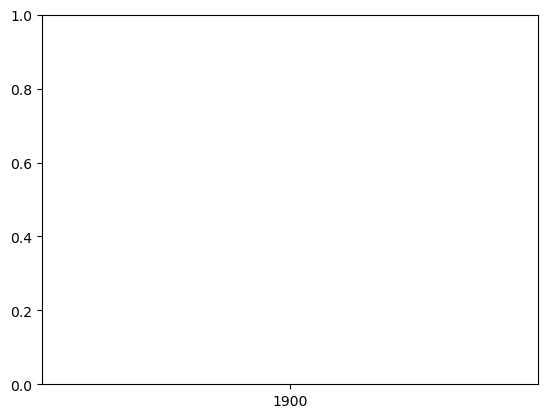

In [88]:
import matplotlib.pyplot as plt
import numpy as np


for bird, freq in frequency.items():
  srt = {k: v for k, v in sorted(freq.items(), key=lambda item: item[0])}
  if frequency[bird]["1900"]["freq"] > 0.25:
    plt.plot(srt.keys(), srt.values(), label=bird)

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()



In [ ]:
wordSearches = ["Stockholm", "Göteborg", "morgon", "natt", "skola", "land", "hafvet"]

In [ ]:
print("bird\t| Stockholm \t| Göteborg \t| morgon \t| natt \t| skola | land \t| hafvet \t|")
for bird, freq in frequency.items():
  srt = {k: v for k, v in sorted(freq.items(), key=lambda item: item[0])}
  if frequency[bird]["1900"] > 0.25:
    wordCounts = [0,0,0,0,0,0,0]
    for i,ws in enumerate(wordSearches):
      try:
        wordCounts[i] = cooccurenceMatrix[bird].get(ws)
      except:
        wordCounts[i] = 0
      
    printString = "{}\t| {} \t\t| {} \t\t| {} \t\t| {} \t| {} \t| {} \t| {} \t\t|".format(bird, wordCounts[0],wordCounts[1],wordCounts[2],wordCounts[3],wordCounts[4],wordCounts[5],wordCounts[6])
    print(printString)

bird	| Stockholm 	| Göteborg 	| morgon 	| natt 	| skola | land 	| hafvet 	|
Fågel	| 1324 		| 339 		| 329 		| 117 	| 614 	| 489 	| 209 		|
Korp	| 292 		| 51 		| 130 		| 16 	| 115 	| 78 	| 23 		|
Orre	| 491 		| 128 		| 60 		| 19 	| 141 	| 48 	| 14 		|
Råka	| 520 		| 139 		| 126 		| 62 	| 493 	| 213 	| 32 		|
Skata	| 164 		| 33 		| 30 		| 7 	| 54 	| 42 	| 10 		|
Stare	| 667 		| 84 		| 102 		| 19 	| 221 	| 71 	| 21 		|
Svärta	| 186 		| 38 		| 44 		| 12 	| 68 	| 38 	| 13 		|
Tjäder	| 672 		| 181 		| 78 		| 13 	| 164 	| 82 	| 14 		|


In [ ]:
sortCooccurence(cooccurenceMatrix["Korp"])

[('och', 6010),
 ('i', 5459),
 ('af', 3835),
 ('att', 3222),
 ('till', 2564),
 ('en', 2559),
 ('den', 2446),
 ('som', 2336),
 ('för', 2257),
 ('med', 1877),
 ('på', 1834),
 ('det', 1521),
 ('de', 1471),
 ('—', 1275),
 ('är', 1159),
 ('ett', 1148),
 ('sig', 1043),
 ('vid', 1038),
 ('har', 997),
 ('om', 963),
 ('från', 861),
 ('han', 823),
 ('m', 691),
 ('å', 675),
 ('man', 660),
 ('under', 630),
 ('var', 598),
 ('ej', 581),
 ('I', 562),
 ('så', 540),
 ('samt', 526),
 ('kr', 520),
 ('kl', 502),
 ('1', 496),
 ('icke', 493),
 ('sin', 490),
 ('A', 459),
 ('år', 429),
 ('då', 427),
 ('hade', 427),
 ('skulle', 393),
 ('nu', 390),
 ('där', 389),
 ('men', 387),
 ('jag', 385),
 ('ha', 366),
 ('Det', 363),
 ('denna', 348),
 ('eller', 345),
 ('andra', 340),
 ('efter', 335),
 ('vi', 331),
 ('e', 327),
 ('än', 325),
 ('mot', 313),
 ('Den', 312),
 ('öfver', 308),
 ('äro', 297),
 ('hans', 296),
 ('genom', 294),
 ('Stockholm', 292),
 ('äfven', 286),
 ('En', 286),
 ('detta', 284),
 ('dag', 282),
 ('alla